In [1]:
# !apt install git
# !apt install wget

In [2]:
# !pip install -U pip numpy
# !pip install hdbscan
# !pip install fastcluster 
# !pip install sklearn-som
#!pip install genieclust

# 2d dataset

We will analyze the dataset other/chameleon_t7_10k, which contains 2d data for clustering.

We will download the dataset from github.

In [3]:
import numpy as np

github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"
#other/chameleon_t7_10k, h2mg/h2mg_128_90
dataset = "other/chameleon_t7_10k" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

--2022-08-13 20:16:19--  https://github.com/gagolews/clustering_benchmarks_v1/raw/master/other/chameleon_t7_10k.data.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/other/chameleon_t7_10k.data.gz [following]
--2022-08-13 20:16:19--  https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/other/chameleon_t7_10k.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89076 (87K) [application/octet-stream]
Saving to: ‘chameleon_t7_10k.data.gz.1’

chameleon_t7_10k.da 100%[===================>]  86,99K  --.-KB/s    in 0,1s

In [4]:
# load data into a numpy array
X = np.loadtxt(dataset.split("/")[1]+".data.gz")


labels_true  = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)

# The number of unique labels gives the true cluster count:
n_clusters = len(np.unique(labels_true))

print('# of clusters: ', n_clusters)
print('# of data', X.shape[0])
print('Unique classes: ', np.unique(labels_true))

# of clusters:  10
# of data 10000
Unique classes:  [0 1 2 3 4 5 6 7 8 9]


Let us visualize the dataset

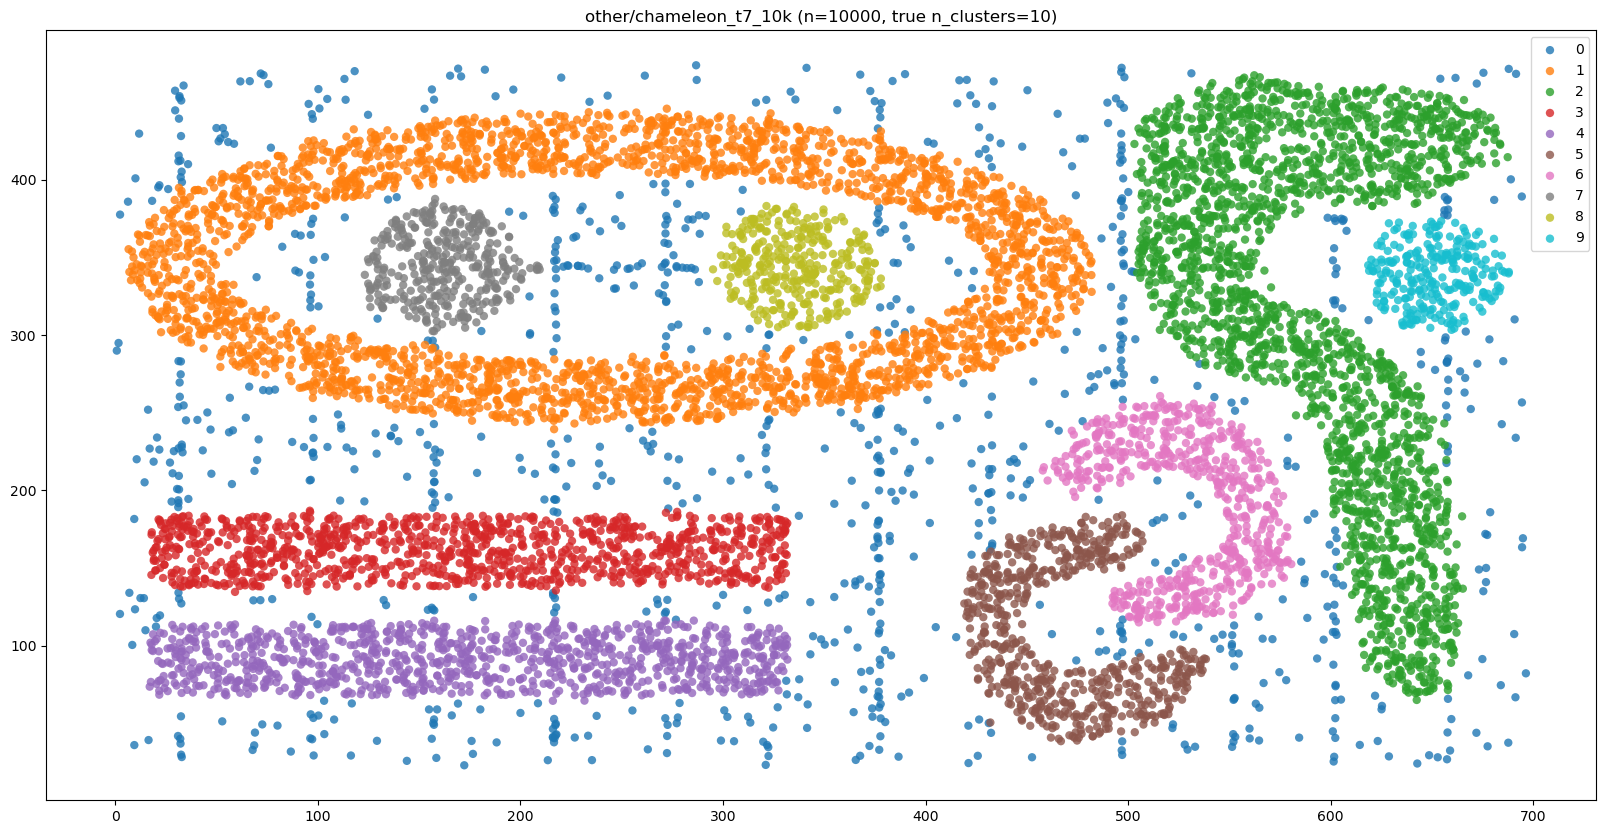

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for cluster in np.unique(labels_true):
  ax.scatter(X[labels_true == cluster][:,0], X[labels_true == cluster][:,1],
               label = cluster, alpha=0.8, edgecolors='none')

plt.legend()
plt.title("%s (n=%d, true n_clusters=%d)" % (dataset, X.shape[0], n_clusters))
fig.set_figheight(10)
fig.set_figwidth(20)

fig

Όπως μπορούμε να δούμε, τα παραπάνω cluster είναι διαφόρων ειδών, με αποτέλεσμα κάποιοι αλγόριθμοι να δουλεύουν καλύτερα σε κάποια cluster από άλλους... Παρακάτω θα φέρουμε όλους τους αλγορίθμους clustering που θα χρησιμοποιήσουμε. 

In [5]:
import time
import sklearn
import genieclust
from hdbscan import HDBSCAN as hdbscan
from fastcluster import linkage
from sklearn_som.som import SOM as som
from sklearn.cluster import DBSCAN as dbscan
from sklearn.mixture import GaussianMixture as gmm
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fcluster

ModuleNotFoundError: No module named 'genieclust'

We will also use different clustering metrics. 

In [7]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

In [8]:
print('True Labels silhouette score: ', silhouette_score(X, labels_true))

True Labels silhouette score:  -0.07670685805135134


The aforementioned score expresses how the clusters found (here given by true labels) are overlapping. If positive, it is a good sign for clustering. If negative, it means that the clusters are overlapping and is not obvious where a point should be actually clustered.

In [9]:
class hac():
  def __init__(self, method, n_clusters):
    self.method = method
    self.n_clusters = n_clusters
  def fit_predict(self, X):
    return fcluster(linkage(X, method=self.method), 
                    self.n_clusters, criterion='maxclust')
    


def model_evaluation(X, y_true, model, name, plot = True):
  #this function calculates all of the relevant scores
  #and plots the cluster graphs.

  #fit n predict
  start = time.time()
  y_pred = model.fit_predict(X)
  times = time.time() - start
  #determining and plotting scores...
  print('Silhouette score: ', silhouette_score(X, y_pred))
  rand = rand_score(labels_true, y_pred)
  print('Rand score: ', rand)
  ad_mutual_info = adjusted_mutual_info_score(labels_true, y_pred)
  print('Adjusted mutual info: ',ad_mutual_info)
  v_measure = v_measure_score(labels_true, y_pred)
  print('V measure score: ', v_measure)

  if plot:
    #plotting cluster graphs...
    plt.figure(figsize=(20, 8), dpi=80)
    for i, title in enumerate(['True labels', name]):
      if i == 1:
        labels = y_pred
      else:
        labels = y_true
      plt.subplot(1, 2, i+1)
      genieclust.plots.plot_scatter(X, labels=labels)
      plt.title('Predicted labels using '+ title)
      plt.axis("equal")
    
    plt.show()

  return y_pred, rand, ad_mutual_info, v_measure, times

In [10]:
import itertools

def plot_confusion_matrix(y_true, y_pred, title='Confusion matrix',cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [11]:
names = []
y_pred_collection = []
rand_collection = []
mutual_info_collection = []
v_measure_collection = []
times_collection = []

## KMeans

Silhouette score:  0.4066482648715739
Rand score:  0.8442282228222823
Adjusted mutual info:  0.5618773490802055
V measure score:  0.5627035702798137


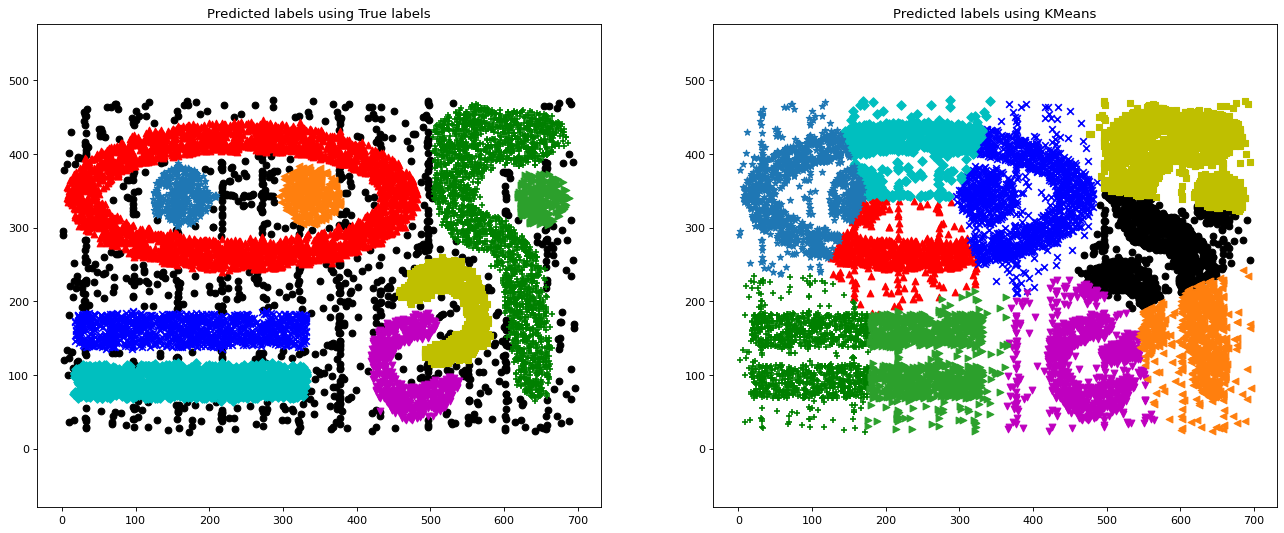

In [12]:
model = KMeans(n_clusters=10)
name = 'KMeans'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## gmm

Silhouette score:  0.3736419064524682
Rand score:  0.8465924592459246
Adjusted mutual info:  0.5998023207264369
V measure score:  0.600557248030819


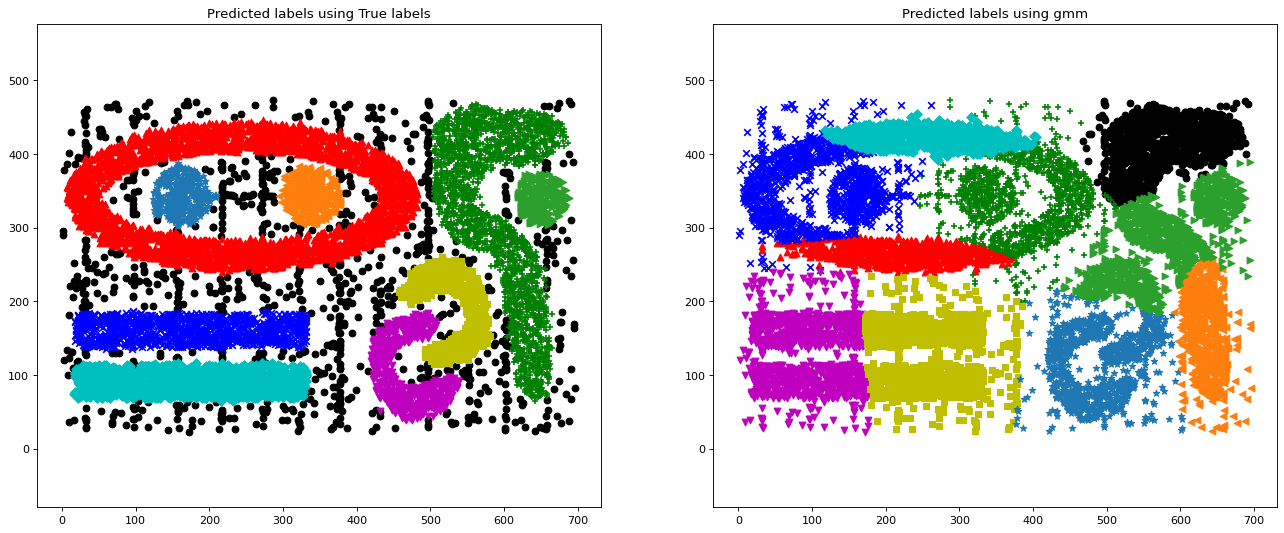

In [13]:
model = gmm(n_components=10)
name = 'gmm'

names.append(name)
y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## som

Silhouette score:  0.32225977354995805
Rand score:  0.8345434743474347
Adjusted mutual info:  0.5383300492633551
V measure score:  0.5391988226574402


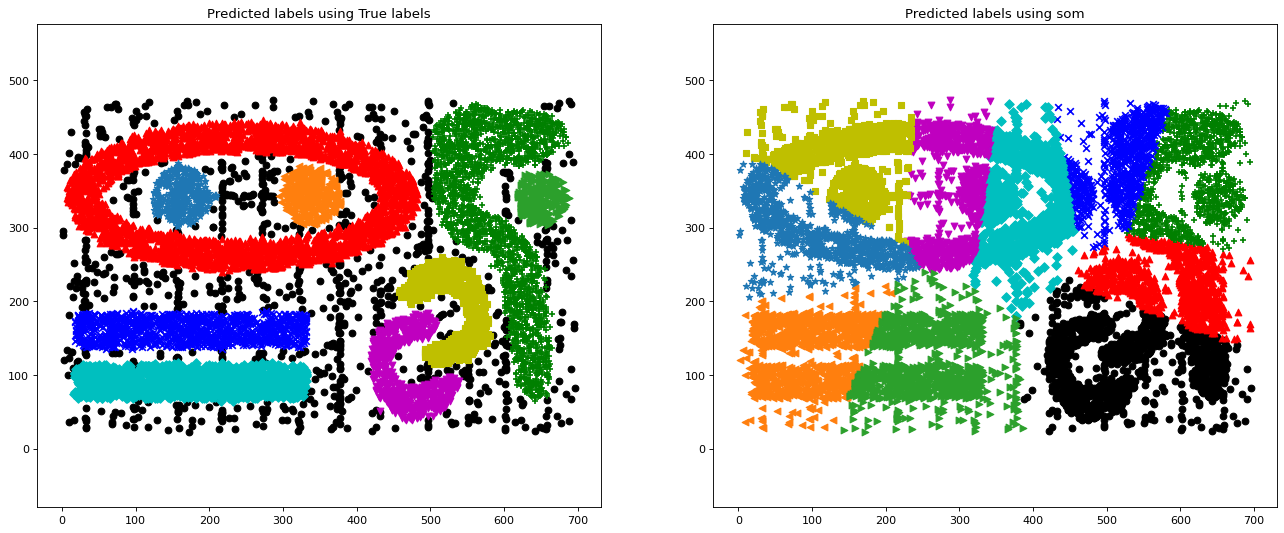

In [14]:
model = som(m=10, n=1, dim=2)
name = 'som'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## hac method single

Silhouette score:  -0.5372319601325146
Rand score:  0.16374231423142313
Adjusted mutual info:  0.001342054580007586
V measure score:  0.0034978631654802557


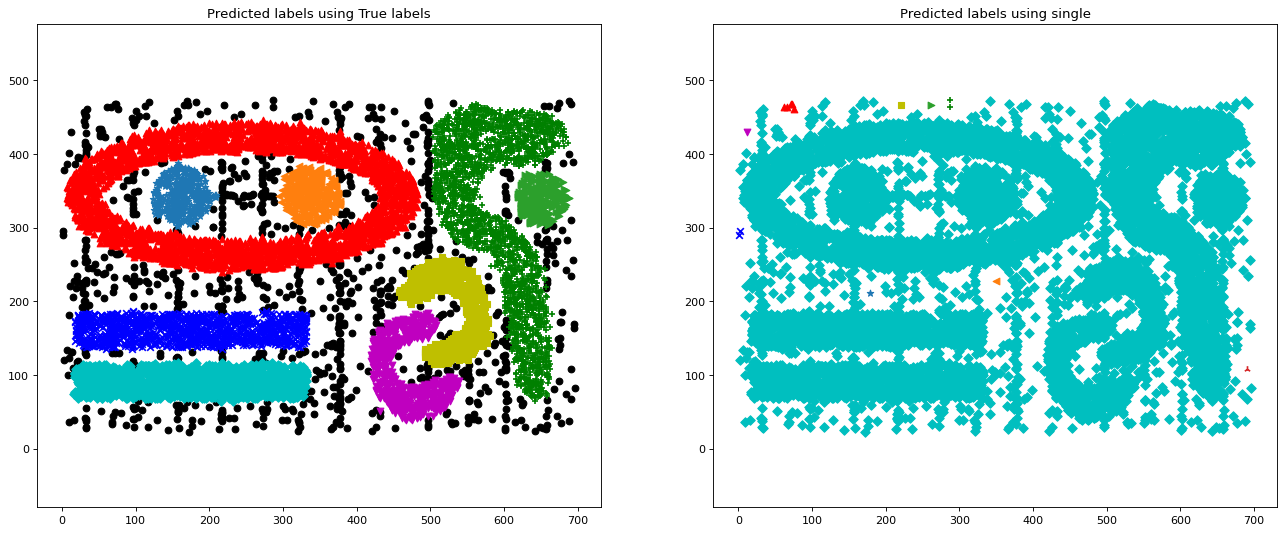

In [15]:
model = hac('single', 10)
name = 'single'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## hac method average

Silhouette score:  0.36485814677070605
Rand score:  0.8564736473647365
Adjusted mutual info:  0.6148728630426525
V measure score:  0.615612173750546


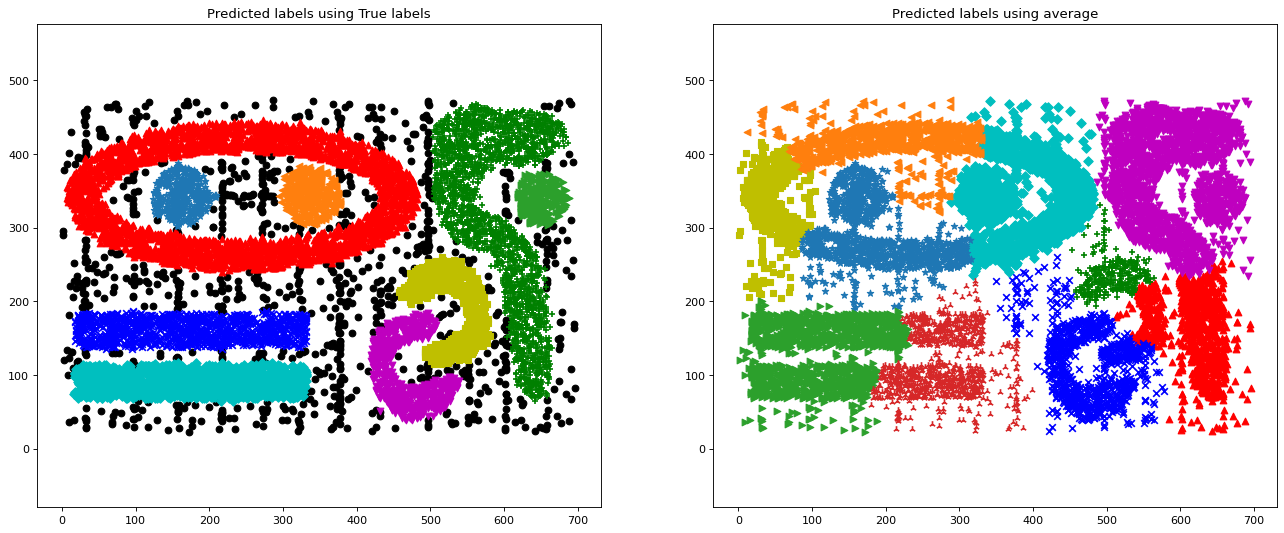

In [16]:
model = hac('average', 10)
name = 'average'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## hac method complete

Silhouette score:  0.2979462139531718
Rand score:  0.8393220722072208
Adjusted mutual info:  0.5305203691022805
V measure score:  0.5314178157509168


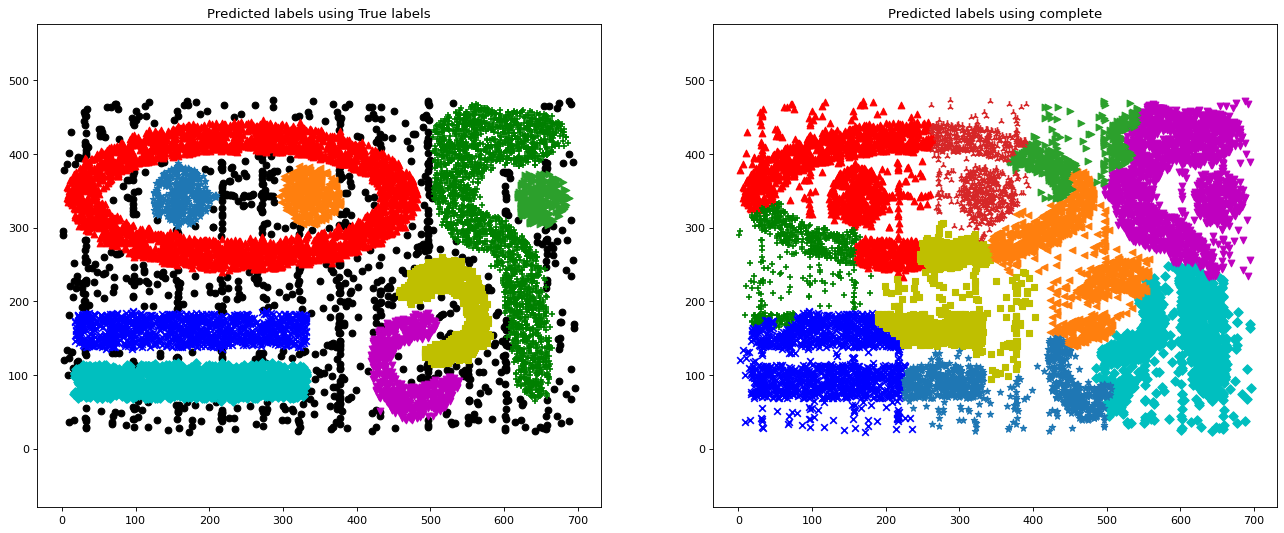

In [17]:
model = hac('complete', 10)
name = 'complete'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## hac method ward

Silhouette score:  0.3583535645506522
Rand score:  0.8587545754575457
Adjusted mutual info:  0.6309676396599083
V measure score:  0.631668328604893


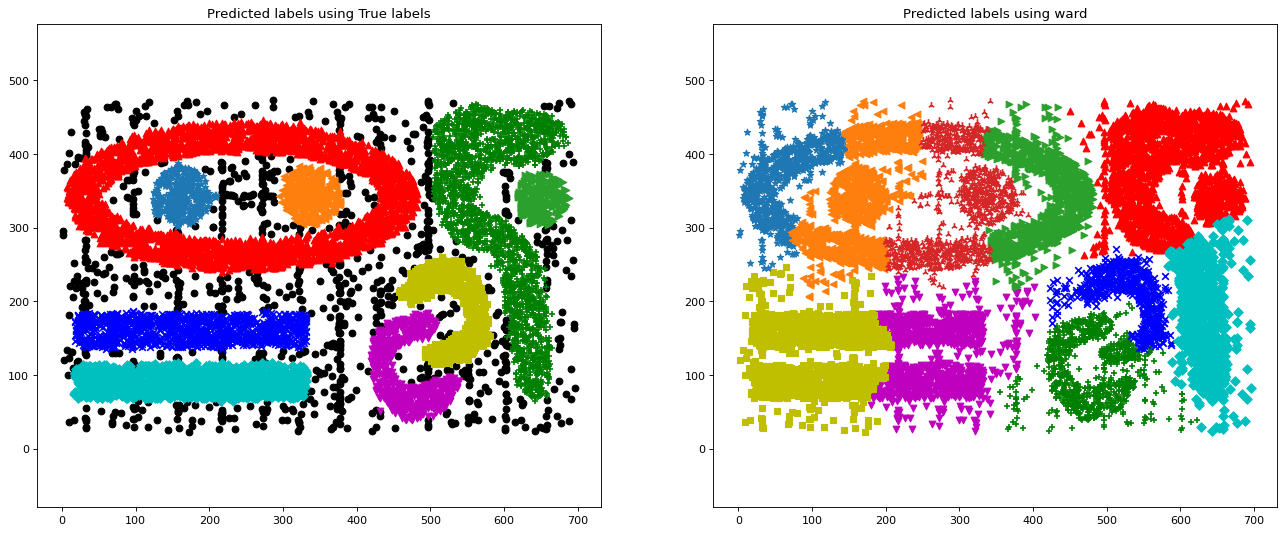

In [18]:
model = hac('ward', 10)
name = 'ward'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## dbscan (sklearn)

Silhouette score:  0.0584899461441903
Rand score:  0.9527215921592159
Adjusted mutual info:  0.8840308022442656
V measure score:  0.8842214495500398


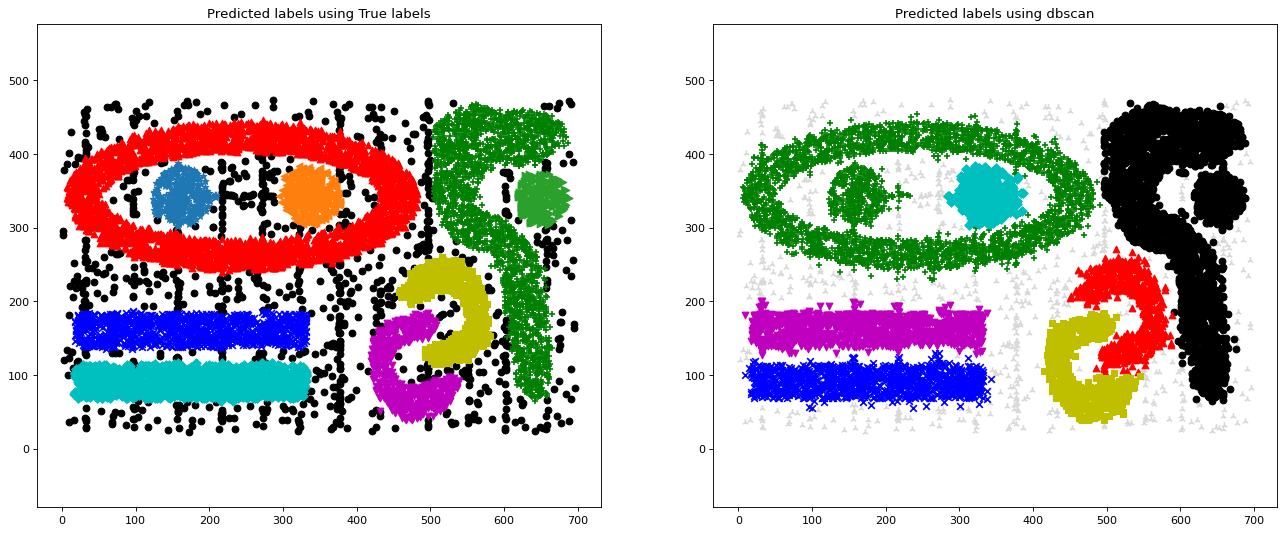

In [19]:
model = dbscan(eps=12, min_samples=12)
name = 'dbscan'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

## hdbscan

Silhouette score:  -0.08122479895366398
Rand score:  0.9878924292429243
Adjusted mutual info:  0.9459703198933768
V measure score:  0.9460784009816415


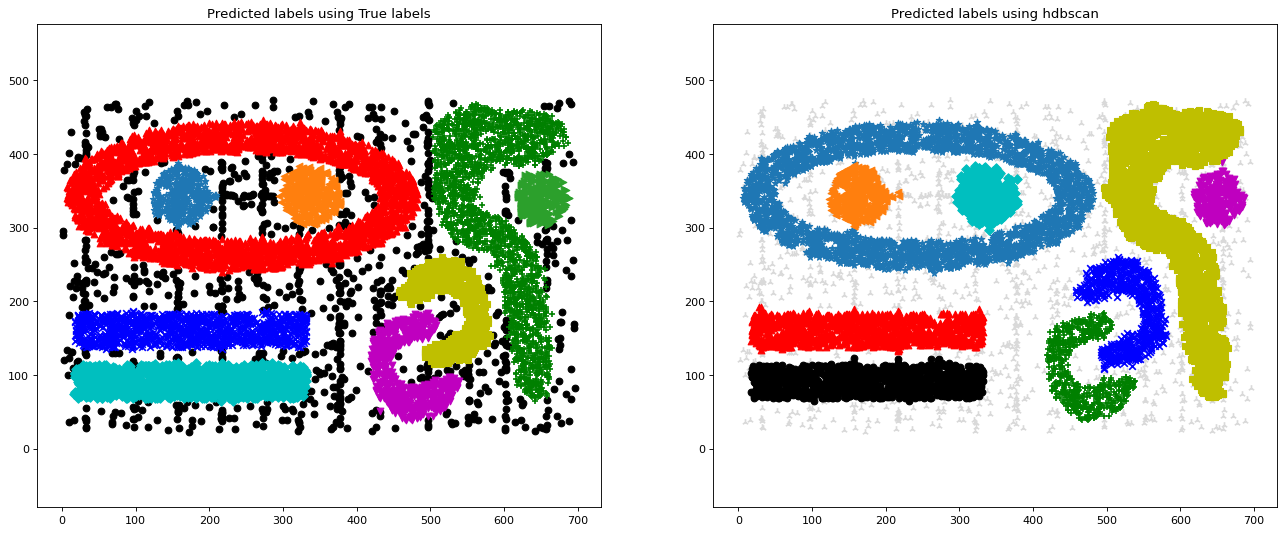

In [20]:
model = hdbscan(min_cluster_size=15, min_samples=12,cluster_selection_epsilon = 10, cluster_selection_method= 'leaf')
name = 'hdbscan'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = True)

y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

In [21]:
import pandas as pd
df_models = pd.DataFrame({'models': names, 'Rand score':rand_collection,\
    'mutual info':mutual_info_collection, 'v measure': v_measure_collection, 'Time (sec)': times_collection})

df_models

,models,Rand score,mutual info,v measure,Time (sec)
0,KMeans,0.844228,0.561877,0.562704,2.379847
1,gmm,0.846592,0.599802,0.600557,0.848034
2,som,0.834543,0.538330,0.539199,2.280509
3,single,0.163742,0.001342,0.003498,2.013027
4,average,0.856474,0.614873,0.615612,5.878325
5,complete,0.839322,0.530520,0.531418,3.091096
6,ward,0.858755,0.630968,0.631668,1.663078
7,dbscan,0.952722,0.884031,0.884221,0.098222
8,hdbscan,0.987892,0.945970,0.946078,0.227293


[-1  0  1  2  3  4  5  6  7  8]


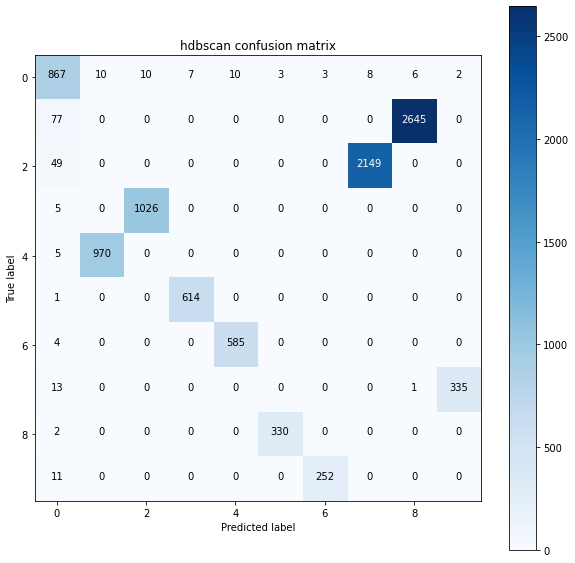

In [22]:
print(np.unique(y_pred_collection[8]))
plot_confusion_matrix(labels_true, y_pred_collection[8] + 1, 'hdbscan confusion matrix')

[ 1  2  3  4  5  6  7  8  9 10]


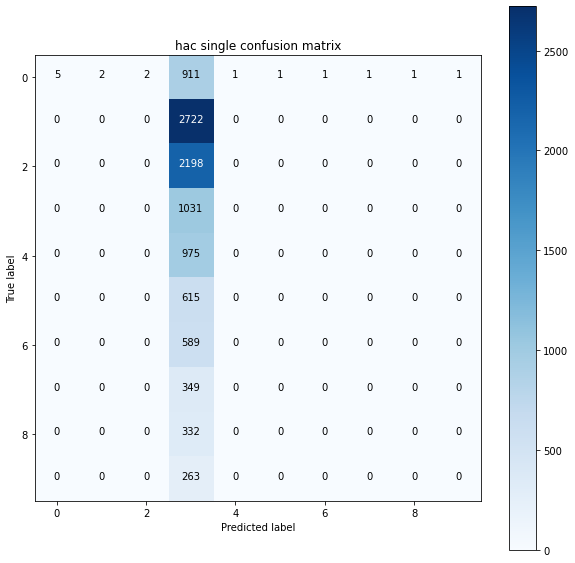

In [23]:
print(np.unique(y_pred_collection[3])) 
plot_confusion_matrix(labels_true, y_pred_collection[3] - 1, 'hac single confusion matrix')

# big dataset
Here we will use the dataset h2mg_128_90, which contains data in higher dimensions (than 2) for clustering.

In [24]:
github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"
#other/chameleon_t7_10k, h2mg/h2mg_128_90
dataset = "h2mg/h2mg_128_90" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

!wget $data_url
!wget $labels_url

--2021-12-20 19:05:06--  https://github.com/gagolews/clustering_benchmarks_v1/raw/master/h2mg/h2mg_128_90.data.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/h2mg/h2mg_128_90.data.gz [following]
--2021-12-20 19:05:06--  https://raw.githubusercontent.com/gagolews/clustering_benchmarks_v1/master/h2mg/h2mg_128_90.data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 497217 (486K) [application/octet-stream]
Saving to: ‘h2mg_128_90.data.gz’

h2mg_128_90.data.gz 100%[===================>] 485.56K  --.-KB/s    in 0.04s   

2021-12-20 19:05:06 (12.9 MB/s) -

In [25]:
# load data into a numpy array
X = np.loadtxt(dataset.split("/")[1]+".data.gz")

#-1 για να αποκτήσω [0, 1] κλάσεις.
labels_true  = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc)-1

# The number of unique labels gives the true cluster count:
n_clusters = len(np.unique(labels_true))
n_features = X.shape[1]
print('# of clusters: ', n_clusters)
print('# of data', X.shape[0])
print('Unique classes: ', np.unique(labels_true))
print('# of features: ', n_features)
print('# of features in cluster 0', X[labels_true==0].shape[0])
print('# of features in cluster 1', X[labels_true==1].shape[0])

# of clusters:  2
# of data 2048
Unique classes:  [0 1]
# of features:  128
# of features in cluster 0 1024
# of features in cluster 1 1024


Since our data are few with regards to their high dimensionality,it would be prudent to lower data dimensiolality.

In [26]:
X.std(axis = 0)

array([1046.08562603, 1043.10165445, 1034.52939558, 1063.16665048,
       1033.20924627, 1037.18061215, 1016.93400517,  998.82741983,
        983.94773781, 1041.14614693, 1004.6003595 ,  987.26488282,
        978.84421804, 1017.99078687, 1067.67382812,  991.81234531,
       1033.17932056, 1017.76667882, 1020.09929827, 1031.21124852,
       1047.71205962,  998.37676354, 1005.21674189, 1014.43059413,
       1017.05816847, 1033.03360251, 1024.9855164 , 1026.75538428,
       1049.89310108,  925.43585759,  998.06626768, 1045.3662674 ,
       1065.283322  , 1036.81143682, 1061.06104002, 1038.67589814,
       1020.75704542, 1036.54772678,  958.865181  ,  966.85718495,
        974.50658582, 1008.61926629, 1081.25593477,  994.24060836,
       1036.31425897, 1063.58806777,  984.36910924, 1016.84418863,
       1022.49974043, 1050.55575437, 1056.67410853, 1034.98135667,
       1055.37285064, 1080.43885656, 1035.68668104,  991.10069704,
       1044.27501146, 1037.88548065, 1035.2270823 , 1040.25178

Let us use PCA

1st PCA component percentage of explaining our data 0.017610720307896358
Explanation of data keeping only the first 100 of pca components 0.8868162873343461


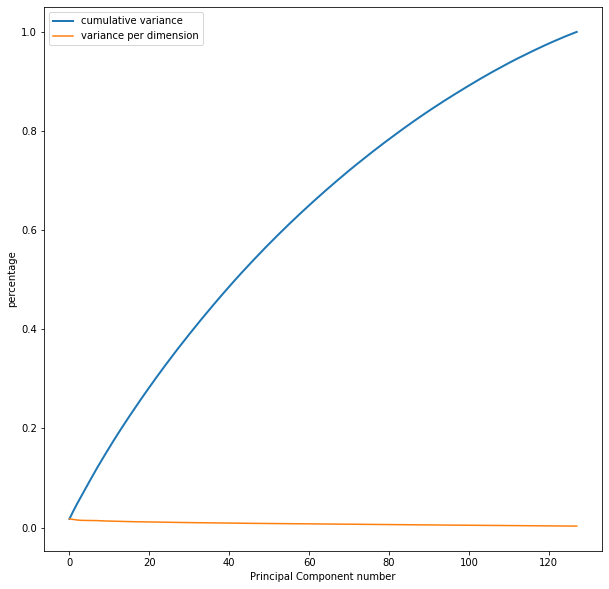

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)

pca.fit(X)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print('1st PCA component percentage of explaining our data', cum_evar[0])
print('Explanation of data keeping only the first 100 of pca components', cum_evar[99])
plt.figure(1, figsize=(10, 10))
plt.xlabel("Principal Component number")
plt.ylabel('percentage')
plt.plot(cum_evar, linewidth=2, label='cumulative variance')
plt.plot(evar, label='variance per dimension')
plt.legend()
plt.show()

Unfortunately PCA won't help...

If we use SVD...

1st PCA component percentage of explaining our data 0.010380845681370226
Explanation of data keeping only the first 100 of pca components 0.8865772534412726


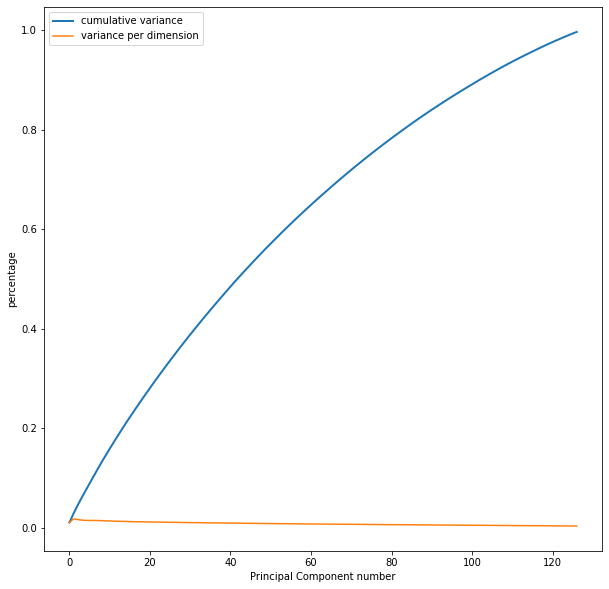

In [28]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=127, n_iter=7, random_state=42)
svd.fit(X)

evar = svd.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print('1st PCA component percentage of explaining our data', cum_evar[0])
print('Explanation of data keeping only the first 100 of pca components', cum_evar[99])
plt.figure(1, figsize=(10, 10))
plt.xlabel("Principal Component number")
plt.ylabel('percentage')
plt.plot(cum_evar, linewidth=2, label='cumulative variance')
plt.plot(evar, label='variance per dimension')
plt.legend()
plt.show()

Again no help

In [29]:
print('True Labels silhouette score: ', silhouette_score(X, labels_true))

True Labels silhouette score:  0.005308711116756036


In [30]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [31]:
names = []
y_pred_collection = []
rand_collection = []
mutual_info_collection = []
v_measure_collection = []
times_collection = []

## KMeans

In [32]:
model = KMeans(n_clusters=2, n_init=200)
name = 'KMeans'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print('Unique clusters: ',np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.3487961969999571
Rand score:  0.5000305324865657
Adjusted mutual info:  0.0011263836663152585
V measure score:  0.0016133231634557358
Unique clusters:  [0 1]
Members of clusters  [1856, 192]


## gmm

In [33]:

model = gmm(n_components=2, n_init=200, max_iter=100)
name = 'gmm'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.1927431026121436
Rand score:  0.4997676668600391
Adjusted mutual info:  -0.0003358451871857291
V measure score:  1.729900808614955e-05
[0 1]
Members of clusters  [1091, 957]


## som

In [34]:
model = som(m=2, n=1, dim=X.shape[1])
name = 'som'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.11473316036133421
Rand score:  0.5005972917684416
Adjusted mutual info:  0.0012380881727118728
V measure score:  0.001617297392184058
[0 1]
Members of clusters  [576, 1472]


## hac method single

In [35]:
model = hac('single', 2)
name = 'single'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.6632281596338004
Rand score:  0.49975621717757696
Adjusted mutual info:  2.374820230328942e-16
V measure score:  0.0009710074111617752
[1 2]
Members of clusters  [2047, 1]


## hac method average

In [36]:
model = hac('average', 2)
name = 'average'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.6632281596338004
Rand score:  0.49975621717757696
Adjusted mutual info:  2.374820230328942e-16
V measure score:  0.0009710074111617752
[1 2]
Members of clusters  [2047, 1]


## hac method complete

In [37]:
model = hac('complete', 2)
name = 'complete'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.6632281596338004
Rand score:  0.49975621717757696
Adjusted mutual info:  2.374820230328942e-16
V measure score:  0.0009710074111617752
[1 2]
Members of clusters  [2047, 1]


## hac method ward

In [38]:
model = hac('ward', 2)
name = 'ward'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.6632281596338004
Rand score:  0.49975621717757696
Adjusted mutual info:  2.374820230328942e-16
V measure score:  0.0009710074111617752
[1 2]
Members of clusters  [2047, 1]


## dbscan

In [39]:
model = dbscan(eps=12, min_samples=4)
name = 'dbscan'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  0.32287175783714567
Rand score:  0.5000782394968246
Adjusted mutual info:  0.0002327056310081884
V measure score:  0.0006109628733763158
[-1  0]
Members of clusters  [586, 1462]


## hdbscan

In [40]:
model = hdbscan()
name = 'hdbscan'

names.append(name)

y_pred, rand, ad_mutual_info, v_measure, times = model_evaluation(X, labels_true, model, name, plot = False)
print(np.unique(y_pred))
print('Members of clusters ', [X[y_pred == cluster].shape[0] for cluster in np.unique(y_pred)])
y_pred_collection.append(y_pred)
rand_collection.append(rand)
mutual_info_collection.append(ad_mutual_info)
v_measure_collection.append(v_measure)
times_collection.append(times)

Silhouette score:  -0.3522486919387894
Rand score:  0.5027741626465559
Adjusted mutual info:  0.10466621783903392
V measure score:  0.10552899438990096
[-1  0  1]
Members of clusters  [1889, 78, 81]


In [41]:
df_models = pd.DataFrame({'models': names, 'Rand score':rand_collection,\
    'mutual info':mutual_info_collection, 'v measure': v_measure_collection, 'Time (sec)': times_collection})

df_models

,models,Rand score,mutual info,v measure,Time (sec)
0,KMeans,0.500031,1.126384e-03,0.001613,3.969222
1,gmm,0.499768,-3.358452e-04,0.000017,47.100702
2,som,0.500597,1.238088e-03,0.001617,0.522817
3,single,0.499756,2.374820e-16,0.000971,0.221390
4,average,0.499756,2.374820e-16,0.000971,0.255236
5,complete,0.499756,2.374820e-16,0.000971,0.265277
6,ward,0.499756,2.374820e-16,0.000971,0.249164
7,dbscan,0.500078,2.327056e-04,0.000611,0.150741
8,hdbscan,0.502774,1.046662e-01,0.105529,1.188684


[0 1]


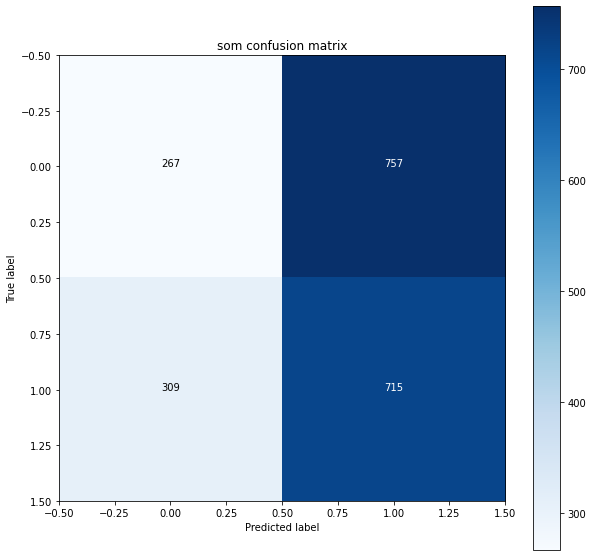

In [42]:
print(np.unique(y_pred_collection[2]))
plot_confusion_matrix(labels_true, y_pred_collection[2], 'som confusion matrix')

[-1  0  1]


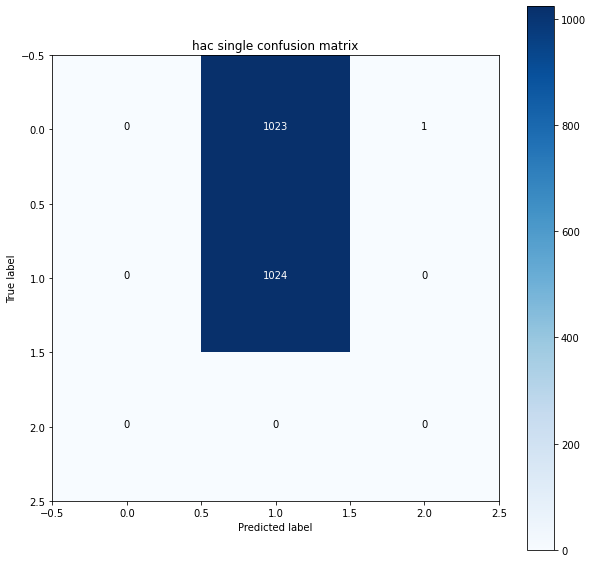

In [43]:
print(np.unique(y_pred_collection[3]))
plot_confusion_matrix(labels_true, y_pred_collection[3], 'hac single confusion matrix')